Above in Runtime --> Change Runtime Type : you can select GPU Acceleration

# DETECTING ANCIENT VILLAGES

Project about detecting presence of rest of ancient village from geographical images.

## PREPROCESSING

Mounting Google Drive to get access to data

In [0]:
# mount google drive to have access
from google.colab import drive
drive.mount('/content/drive')
# https://drive.google.com/drive/u/0/folders/1zOJ3p--7GxP7gv7V3uNdvXvEeArMUS-Z

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### INSTALLING DEPENDENCIES

In [0]:
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 207kB/s 
     |████████████████████████████████| 10.9MB 40.6MB/s 
     |████████████████████████████████| 18.2MB 1.4MB/s 


### IMPORTING EVERYTHING WE NEED

In [0]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from shutil import copyfile
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import rasterio
import shutil
import random

os.getcwd()

'/content'

### CHECKS

Checking out that everything is in the project folder as we thought

In [0]:
project_folder = "/content/drive/My Drive/Detecting Ancient Villages"
print(os.listdir(project_folder))

['data_gt_complete.zip', 'Detecting Ancient Villages']


In [0]:
!unzip -q "/content/drive/My Drive/Detecting Ancient Villages/data_gt_complete.zip"

In [0]:
try:
    os.mkdir('data/derived_data/negative_examples')

except OSError:
    pass

## DATA PREPARATION

Start to read the data and prepare the division into confirmed site (images where we know there is a tell), negative site (images where we know that there is not) and random sites (where we cannot say beforehand what is there.

In [0]:
# Data
datadir = os.getcwd()
tell_sites = gpd.read_file("data/raw_data/tell_sites.geojson").to_crs({'init': 'epsg:32637'})
poly = tell_sites.copy()
directory = r'data/derived_data/tiles'

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


This is the code that we use to move the images of the confirmed sites to another folder. We already know which images are confirmed, it's already in the dataset as information (contained in the geojson file)

In [0]:
# import os
# import gdal
# import rasterio
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Point, Polygon
# import shutil

# try:
#     os.mkdir('data\\derived_data')
#     os.mkdir('data\\derived_data\\tiles')
#     os.mkdir('data\\derived_data\\confirmed_sites')

# except OSError:
#     pass

# datadir = os.getcwd()

# # Data
# tell_sites = gpd.read_file("data\\raw_data\\tell_sites.geojson").to_crs({'init': 'epsg:32637'})

# # Preparation for tiling
# data_folder = os.getcwd()+'\\data'
# input_filename = '\\raw_data\\study_area_hillshade_32637_GT.tif'

# out_path = data_folder+'\\derived_data\\tiles\\'
# output_filename = 'tile_'

# # Define tiling size
# gt_dem = rasterio.open(data_folder+input_filename, crs={'init': 'epsg:32637'})

# tile_size_x = np.round(gt_dem.shape[0]/55, 0).astype(int)  # in pixels not metrics!
# tile_size_y = np.round(gt_dem.shape[1]/55, 0).astype(int)

# ds = gdal.Open(data_folder + input_filename)
# band = ds.GetRasterBand(1)
# xsize = band.XSize
# ysize = band.YSize

# # For loop for tiling using GDAL
# for i in range(0, xsize, tile_size_x):
#     for j in range(0, ysize, tile_size_y):
#         com_string = "gdal_translate -of GTIFF -srcwin " + str(i) + ", " + str(j) + ", " + str(
#             tile_size_x) + ", " + str(tile_size_y) + " " + str(data_folder) + str(input_filename) + " " + str(
#             out_path) + str(output_filename) + str(i) + "_" + str(j) + ".tif"
#         os.system(com_string)


# # Loop through directory
# directory = r'data\\derived_data\\tiles'
# findings = []
# sites = gpd.GeoSeries(tell_sites['geometry'], crs='EPSG:32637')

# for filename in os.listdir(directory):
#     raster = rasterio.open(directory+'\\'+filename, crs={'init': 'epsg:32637'})
#     points = [Point(np.asarray(raster.bounds)[0], np.asarray(raster.bounds)[1]),
#               Point(np.asarray(raster.bounds)[2], np.asarray(raster.bounds)[1]),
#               Point(np.asarray(raster.bounds)[2], np.asarray(raster.bounds)[3]),
#               Point(np.asarray(raster.bounds)[0], np.asarray(raster.bounds)[3])]

#     bb = gpd.GeoSeries(Polygon(sum(map(list, (p.coords for p in points)), [])), crs='EPSG:32637')
#     bools = sites.within(bb.loc[0])

#     if True in bools.values:
#         print('Found containing polygon:', filename)
#         findings.append('data\\derived_data\\tiles\\'+filename)

#     else:
#         continue


# # Copy found areas to external folder
# for f in findings:
#     shutil.copy(f, 'data\\derived_data\\confirmed_sites')

We already detected the positive sites, with the code above that now is commented, so now we want to look at the negative sites. We take a 900 meters buffer and we assume that within 900m of a tell there should be no other tell. Then we classify the images within this range as negative sites

In [0]:
# Buffer each point using a 900 meter circle radius
poly["geometry"] = poly.geometry.buffer(900)
poly_g = gpd.GeoSeries(poly['geometry'], crs='EPSG:32637')

findings_negative = []
confirmed_sites = os.listdir('data/derived_data/confirmed_sites')
confirmed_sites = ['data/derived_data/tiles/' + x for x in confirmed_sites]

for filename in os.listdir(directory):
    raster = rasterio.open(directory+'/'+filename, crs={'init': 'epsg:32637'})
    points = [Point(np.asarray(raster.bounds)[0], np.asarray(raster.bounds)[1]),
              Point(np.asarray(raster.bounds)[2], np.asarray(raster.bounds)[1]),
              Point(np.asarray(raster.bounds)[2], np.asarray(raster.bounds)[3]),
              Point(np.asarray(raster.bounds)[0], np.asarray(raster.bounds)[3])]

    bb = gpd.GeoSeries(Polygon(sum(map(list, (p.coords for p in points)), [])), crs='EPSG:32637')
    bools = poly_g.overlaps(bb.loc[0])

    if True in bools.values:
        # print('Found overlapping polygon:', filename)
        findings_negative.append('data/derived_data/tiles/'+filename)

    else:
        continue

We still have too few images, so we need to add some of the images from the random sites. We would like to reach a high amount of data to train accurately the network. 
So we add some images at random.

In [0]:
# Randomely chosen images
print("we found {} negative images where we are pretty sure".format(len(findings_negative)))
number_of_images_we_want_to_have_for_training = 2500 # I define it as a variable so we can change it

all_tiles = os.listdir('data/derived_data/tiles')
all_tiles = ['data/derived_data/tiles/' + x for x in all_tiles]
used_ones = confirmed_sites+findings_negative

for i in used_ones:
    try:
        all_tiles.remove(i)
    except ValueError:
        pass

random_sites = random.sample(all_tiles, number_of_images_we_want_to_have_for_training-len(findings_negative))

we found 218 negative images where we are pretty sure


Here we actually move the image to another folder

In [0]:
# Copy found areas to external folder
print("so now we copy {} negaative images + {} random = {} in total into our negative example folder, that will be used as negative examples".format(len(findings_negative), len(random_sites), len(findings_negative)+len(random_sites)))
for f in findings_negative+random_sites:
    shutil.copy(f, 'data/derived_data/negative_examples')

so now we copy 218 negaative images + 2282 random = 2500 in total into our negative example folder, that will be used as negative examples


Let's make a quick check - how many images and where we have them

In [0]:
print("What do we have now?")
number_of_images = len(os.listdir('data/derived_data/tiles/'))
number_of_positive_images = len(os.listdir('data/derived_data/confirmed_sites/'))
number_of_negative_images = len(os.listdir('data/derived_data/negative_examples/'))
unlabeled_images = number_of_images - number_of_positive_images - number_of_negative_images
print("- {} images in total".format(number_of_images))
print("- {} images labeled as positive example".format(number_of_positive_images))
print("- {} images labeled as negative example".format(number_of_negative_images))
print("- {} unlabeled images".format(unlabeled_images))

What do we have now?
- 3149 images in total
- 50 images labeled as positive example
- 2500 images labeled as negative example
- 599 unlabeled images


It looks like we have a lot of unlabeled images, which is not good. It would be nice to increase a bit the number of "labeled" images for the training.

For the moment we accept it and we create two sets, one big for training (90%), one small for validation (the remaining 10%)

### DIVIDE TRAINING AND VALIDATION DATA

We create the folder structure

In [0]:
# divide the images in folders
# -- data
#  |
#  |--- train
#  |  |
#  |  |-- tell
#  |  |
#  |  |-- notell
#  |  
#  |-- validation
#    |
#    |-- tell
#    |
#    |-- notell
train_dir = 'data' + '/train'
validation_dir = 'data' + '/validation'
class1 = 'tell'
class2 = 'notell'
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)
if not os.path.exists(train_dir + '/' + class1):
  os.mkdir(train_dir + '/' + class1)
if not os.path.exists(train_dir + '/' + class2):
  os.mkdir(train_dir + '/' + class2)
if not os.path.exists(validation_dir + '/' + class1):
  os.mkdir(validation_dir + '/' + class1)
if not os.path.exists(validation_dir + '/' + class2):
  os.mkdir(validation_dir + '/' + class2)

Now we take random image for training and validation sets

In [0]:
# we create two lists with the name of the images
positive_images = os.listdir('data/derived_data/confirmed_sites')
negative_images = os.listdir('data/derived_data/negative_examples')
# we shuffle them
random.shuffle(positive_images)
random.shuffle(negative_images)
# how many images would be 90%?
positive_90 = np.round(len(positive_images) * 0.9).astype(int) # we round to integer
negative_90 = np.round(len(negative_images) * 0.9).astype(int) # we round to integer
remaining_10_positive = len(positive_images) - positive_90
remaining_10_negative = len(negative_images) - negative_90
print("we will use {} positive image and {} negative, so {} in total, for the training".format(positive_90, negative_90, positive_90 + negative_90))
print("and we will use {} positive image and {} negative, so {} in total, for the validation".format(remaining_10_positive, remaining_10_negative, remaining_10_positive + remaining_10_negative))
# split them
train_positive = positive_images[:positive_90] # in python array[:N] means the first N elements
validation_positive = positive_images[-remaining_10_positive:] # in python array[-M:] means the last M elements 
train_negative = negative_images[:negative_90] # in python array[:N] means the first N elements
validation_negative = negative_images[-remaining_10_negative:] # in python array[-M:] means the last M elements 
# we copy them in hte folder. We could have just moved them, but I think there are no space problem, so we can copy everything
for img_path in train_positive:
  copyfile('data/derived_data/confirmed_sites/' + img_path, train_dir + '/tell/' + img_path)
for img_path in train_negative:
  copyfile('data/derived_data/negative_examples/' + img_path, train_dir + '/notell/' + img_path)
for img_path in validation_positive:
  copyfile('data/derived_data/confirmed_sites/' + img_path, validation_dir + '/tell/' + img_path)
for img_path in validation_negative:
  copyfile('data/derived_data/negative_examples/' + img_path, validation_dir + '/notell/' + img_path)

we will use 45 positive image and 2250 negative, so 2295 in total, for the training
and we will use 5 positive image and 250 negative, so 255 in total, for the validation


### HOW DO IMAGES LOOK LIKE?

Let's take a look - first some positive examples!

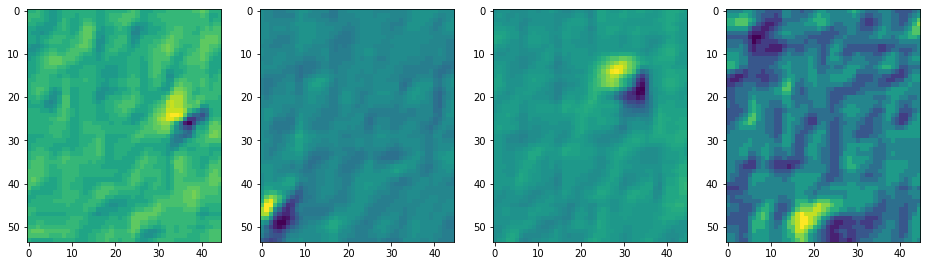

In [0]:
# IMAGES WITH TELL
%matplotlib inline

data_folder = train_dir + '/tell/'
images = os.listdir(data_folder)
random.shuffle(images)
indices = [0, 2, 4, 8]
plt.figure(figsize=(16,8))
plt.title("Images with Tell")

for i, ind in enumerate(indices):
  image_path = data_folder + images[ind]
  image = Image.open(image_path)
  plt.subplot(1, len(indices), i+1)
  plt.imshow(image)

Good! Now some negative examples!

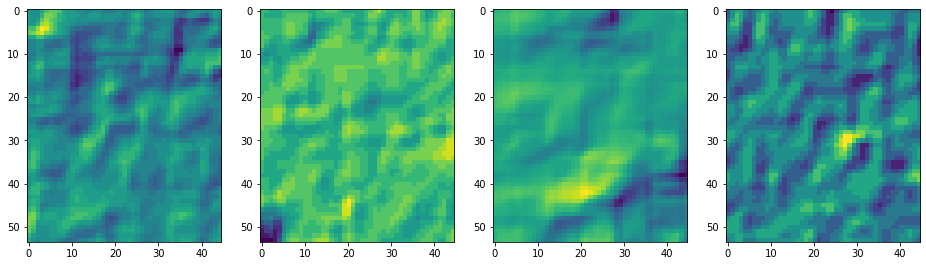

In [0]:
# IMAGE WITHOUT TELL
data_folder_no_tell = train_dir + '/notell/'

images = os.listdir(data_folder_no_tell)
random.shuffle(images)
indices = [0, 2, 4, 8]
plt.figure(figsize=(16,8))
plt.title("Images with no Tell")

for i, ind in enumerate(indices):
  image_path = data_folder_no_tell + images[ind]
  image = Image.open(image_path)
  plt.subplot(1, len(indices), i+1)
  plt.imshow(image)

It looks good, images are quite different!

# AFTER THIS IT DOES NOT WORK CORRECTLY

- I am not sure about which model to use, and the input_shape is not working as expected. The generator creates images with 3 channels, this is weird
- not sure we need the last two layers, maybe only one
- optimizer and loss are just the standard
- some images do not look good, there are black part, probably because of the generator

so, as said, after this is more of an attempt to do something, but it does not work. Feel free to delete and throw away and do something better :)

### DATA GENERATOR FROM TENSORFLOW

Now we can use the data generator from Tensorflow to create our dataset for us in the way tensorflow likes it. This will come in handy later, if we want to add data augmentation or want to make small changes to the code

For more information about ImageDataGenerators, look [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create an ImageDataGenerator
# we rescale image to have values betwen 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# this .flow_from_directory is just telling where the data is, and which kind of class we have
train_generator = train_datagen.flow_from_directory(
        'data/train',
        shuffle=True,
        target_size=(50, 50),
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(50, 50),
        class_mode='binary')

Found 2295 images belonging to 2 classes.
Found 255 images belonging to 2 classes.


Great! It seems that the number coincide with the one we had above, so maybe it's working!

To try to explain the generator, it takes the folder as input `data/train` and `data/validation` and some parameters on how the data should prepared for the training. 

One may ask, why `target_size=(50, 50)`. Good question, somehow Tensorflow loves squared size image, and it will distort the images to make them fit. It is not the best, but at the moment I could not think of a better solution. 

Lastly `class_mode=binary` means we have two classes. We may have to change this if we want to do something else.

We take a quick look about the images when they are fed to the neural network. They are a bit squashed to be squared, but nothing dramatic

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


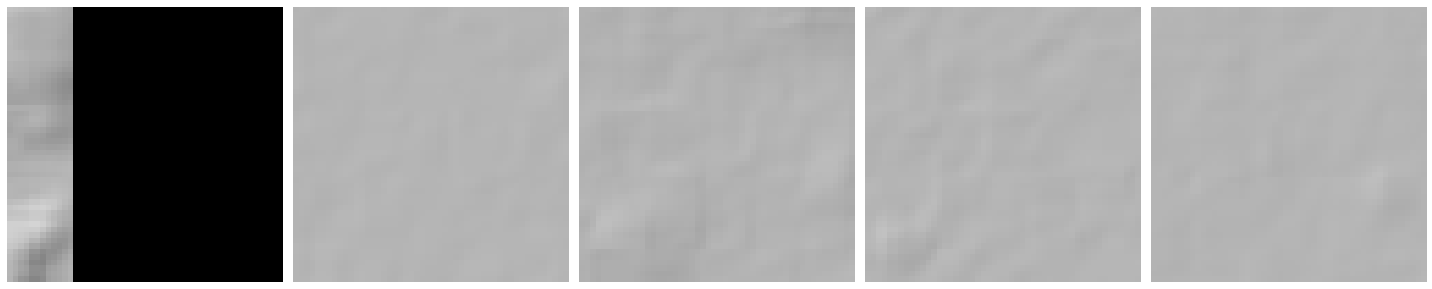

In [0]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

And they are also created as 3 channel images. I am not sure why, or whether this is correct!

## THE MODEL 

Now we can start to think about our neural network. How it should look like, how many layers and hidden units? 
Nobody knows, but we can try to play around a little bit.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

IMG_HEIGHT = 50
IMG_WIDTH = 50

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Here again, some explanation are needed. 
We create a Sequential model (a Sequential allows us to create a network layer by layer, which is fine for our purposes and makes it easier to see). Alternatively, one could use a Functional model. I am not an expert on that, here [an article](https://jovianlin.io/keras-models-sequential-vs-functional/) about that.

So we have first two convolutional layers. The first one has 16 filter kernels, the second one 32. Why these numbers are like this, is hard to say. We should try and see what works better. Usually multiples of 2 are used. 
The max pooling layer is used to group 4 pixels into one, so it works as a down-scaling to simplify stuff.
The flattening actually only reshape the image into a vector, to feed it to the last dense layer. The last layer it has a different activation function, because it needs to classify. So the last `Dense(1)` means we have 1 output neurons which can take the value of `0` --> no tell or `1` --> yes tell!

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

Maybe this helps to visualize the layers one on top of the others. The shape field is interesting, and we see how our image becames smaller and smaller each time a pooling layer is applied!

Also the number of parameters is super high, and that's why we need the training!

But before we need to tell the model which function to use for the training!

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

This also can look a little complicated. 
Basically Adam is one of the most famous optimizers, it is a combination of momentum and RMSProp, if you have heard about that. It is a refined version of Gradient Descent, which exploits the previously computed gradient to ensure training robustness against local minima and speed up training!

The loss function is the binary crossentropy. It is just a way to compute how 'good' the algorithm did, based on our data. It is binary, and gives a positive or negative score if the model did good or bad.

Metrics is what we want to have our training to tell us and plot. It's the standard usually.

## TRAINING

So now we can think about training our model with the data we prepared!

In the training we will define `batch_size` and `epochs` as parameters. 
`batch_size` means we divide our training set in small batches of `batch_size` and feed them to the training until we reached the full length of the dataset.
`epochs` is how many times we run throught the whole dataset. A large number of `epochs` may take a looooong time!

**WARNING: THIS MAY TAKE A WHILE! ENSURE YOU HAVE GPU SELECTED IN RUNTIME!**

In [0]:
# as explained above
batch_size = 8
epochs = 5
# we explain this below
training_size = positive_90 + negative_90
steps_per_epoch = np.floor((training_size // (batch_size * epochs)) - 1).astype(int)
print("we use {} steps per epoch, so for one epoch we use {} images and for {} epochs we use {} images".format(steps_per_epoch, steps_per_epoch * batch_size, epochs, steps_per_epoch * batch_size * epochs))
history = model.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size
)

we use 56 steps per epoch, so for one epoch we use 448 images and for 5 epochs we use 2240 images
Epoch 1/5
56/56 [==============================] - 2s 30ms/step - loss: 0.6987 - accuracy: 0.9637 - val_loss: 0.6931 - val_accuracy: 0.9804
Epoch 2/5
56/56 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.9809 - val_loss: 0.6931 - val_accuracy: 0.9804
Epoch 3/5
56/56 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.9809 - val_loss: 0.6931 - val_accuracy: 0.9804
Epoch 4/5
56/56 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.9804 - val_loss: 0.6931 - val_accuracy: 0.9804
Epoch 5/5
56/56 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.9804 - val_loss: 0.6931 - val_accuracy: 0.9804


It does not look like it learned anything. Let's plot the accuracy

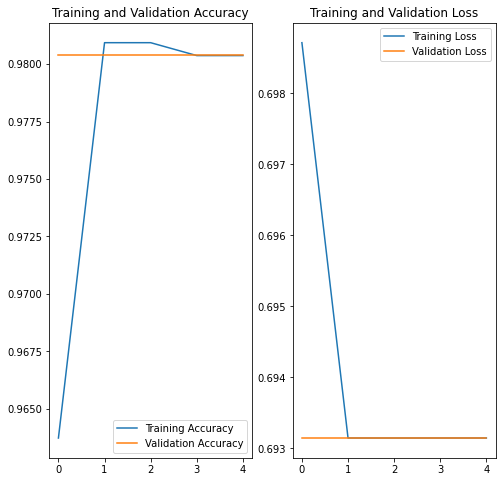

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

No, it definitely did not work :(

We can try to look at some images and what the network tell us about them

this time I try with the 13-th image - label is 0.0 - model predicts [[4.1341123e-24]]
this time I try with the 8-th image - label is 0.0 - model predicts [[9.739915e-25]]
this time I try with the 17-th image - label is 0.0 - model predicts [[1.8248554e-24]]
this time I try with the 6-th image - label is 0.0 - model predicts [[1.2676232e-24]]
this time I try with the 21-th image - label is 0.0 - model predicts [[1.3564692e-24]]


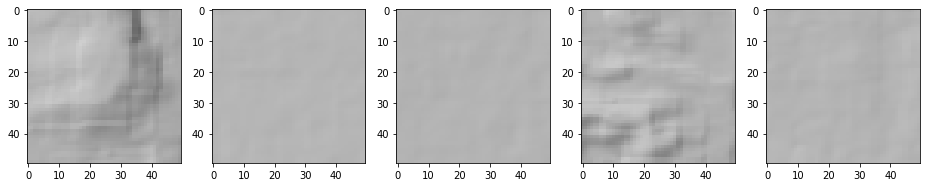

In [0]:
from random import randrange
sample_training_images, labels = next(validation_generator)

how_many_images = 5
plt.figure(figsize=(16,10))
for i in range(how_many_images):
  random_index = randrange(len(sample_training_images))
  
  plt.subplot(1, how_many_images, i+1)
  plt.imshow(sample_training_images[random_index])
  prediction = model.predict(np.expand_dims(sample_training_images[random_index], 0))
  print("this time I try with the {}-th image - label is {} - model predicts {}".format(random_index, labels[random_index], prediction))



Nothing special here

this time I test with the 24-th image - label is 1.0 - model predicts [[1.0896833e-24]]


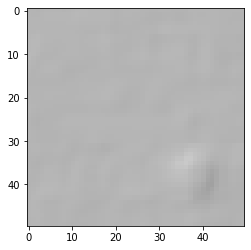

In [0]:
from random import randrange
sample_training_images, labels = next(validation_generator)
with_tell = np.argmax(labels)
plt.figure()
plt.imshow((sample_training_images[with_tell]))
prediction = model.predict(np.expand_dims(sample_training_images[with_tell], 0))
print("this time I test with the {}-th image - label is {} - model predicts {}".format(with_tell, labels[with_tell], prediction))

The positive one also has similar predicted value. 

In [0]:
# Delete all files within folder
def delete_all(folder):
    if not os.path.exists(folder):
        return None
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [0]:
# TODO Move images to train and validation folder
create_folder_structure_for_tensorflow(data_folder = "data/derived_data")

from shutil import copyfile
def copy_all(src, dst):
    files = [src + file_name for file_name in os.listdir(src)]
    [copyfile(file, dst) for file in files]

# Move confirmed tells
copy_all(data_folder + "/derived_data/confirmed_sites", "train/tell")

# Move confirmed non-tells
copy_all(data_folder + "/derived_data/negative_examples", "train/notell")

# Move random unlabeled tiles

NameError: ignored